# 7. Приближенное решение смешанной краевой задачи для волнового уравнения

Требуется найти приближенное решение смешанной краевой задачи для неоднородного волнового уравнения при $ 0 \le x \le 1 $ с помощью схемы "крест" с шагом $ h = 0.05 $ по переменной $ x $.

$$ 2 \frac{\partial^2 u}{\partial t^2}(x, t) = \frac{\partial^2 u}{\partial x^2}(x, t) + 4 \cos (2 + 2t - 2x)$$
$$$$
$$ u(x, 0) = 2 \sin^2 (1 - x), \space \space \frac{\partial u}{\partial t}(x, 0) = 2 \sin (2 - 2x) $$
$$$$
$$ u(0, t) = 2 \sin^2 (1 + t), \space \space u(1, t) + \frac{\partial u}{\partial x}(1, t) = 2 (\sin^2 t - \sin (2t)) $$
$$$$

Решение задачи:
$$ u_0(x, t) = 2 \sin^2 (1 + t - x) $$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def u0(x, t):
    return 2 * np.sin(1 + t - x) ** 2

In [ ]:
a = 2

In [ ]:
def initial_value(x):
    return 2 * np.sin(1 - x) ** 2

def initial_value_dt(x):
    return 2 * np.sin(2 - 2 * x)

In [ ]:
def left_value(t):
    return 2 * np.sin(1 + t) ** 2

In [ ]:
def right_rhs(t):
    return 2 * (np.sin(t) ** 2 - np.sin(2 * t))

def right_value_first_order(u_inside, t):
    return (right_rhs(t) + u_inside[-2] / h) / (1 + 1 / h)

def right_value_second_order(u_inside, t):
    return (right_rhs(t) + (4 * u_inside[-2] - u_inside[-3]) / (2 * h)) / (1 + 3 / (2 * h))

In [ ]:
def f(x, t):
    return 4 * np.cos(2 + 2 * t - 2 * x)

In [ ]:
h = 0.05
tau = 0.03
assert tau <= h / np.sqrt(a),\
       f"Условие устойчивости Куранта не выполнено, tau должно быть меньше {h / np.sqrt(a):.2}"

T = 1

In [ ]:
xs = np.linspace(0, 1, int(1 / h) + 1)
ts = np.linspace(0, T, int(T / tau) + 1)

In [ ]:
def solve():
    u = np.zeros((len(xs), len(ts)))

    u[:, 0] = initial_value(xs)

    for t in range(len(ts) - 1):
        u[0, t + 1] = left_value(ts[t + 1])

        d2u_dx2 = (u[2:, t] - 2 * u[1:-1, t] + u[:-2, t]) / (h ** 2)
        f_x_t = f(xs[1:-1], ts[t])
        if t == 0:
            u[1:-1, 1] = u[1:-1, 0] + tau * initial_value_dt(xs[1:-1]) +\
                (tau ** 2) / (2 * a) * (d2u_dx2 + f_x_t)
        else:
            u[1:-1, t + 1] = 2 * u[1:-1, t] - u[1:-1, t - 1] +\
                (tau ** 2) / a * (d2u_dx2 + f_x_t)

        u[-1, t + 1] = right_value_second_order(u[:, t + 1], ts[t + 1])

    return u

In [ ]:
u = solve()

In [ ]:
def calculate_error(u):
    error = np.zeros_like(u)
    for t in range(len(ts)):
        exact = u0(xs, ts[t])
        error[:, t] = np.abs(u[:, t] - exact)
    return error

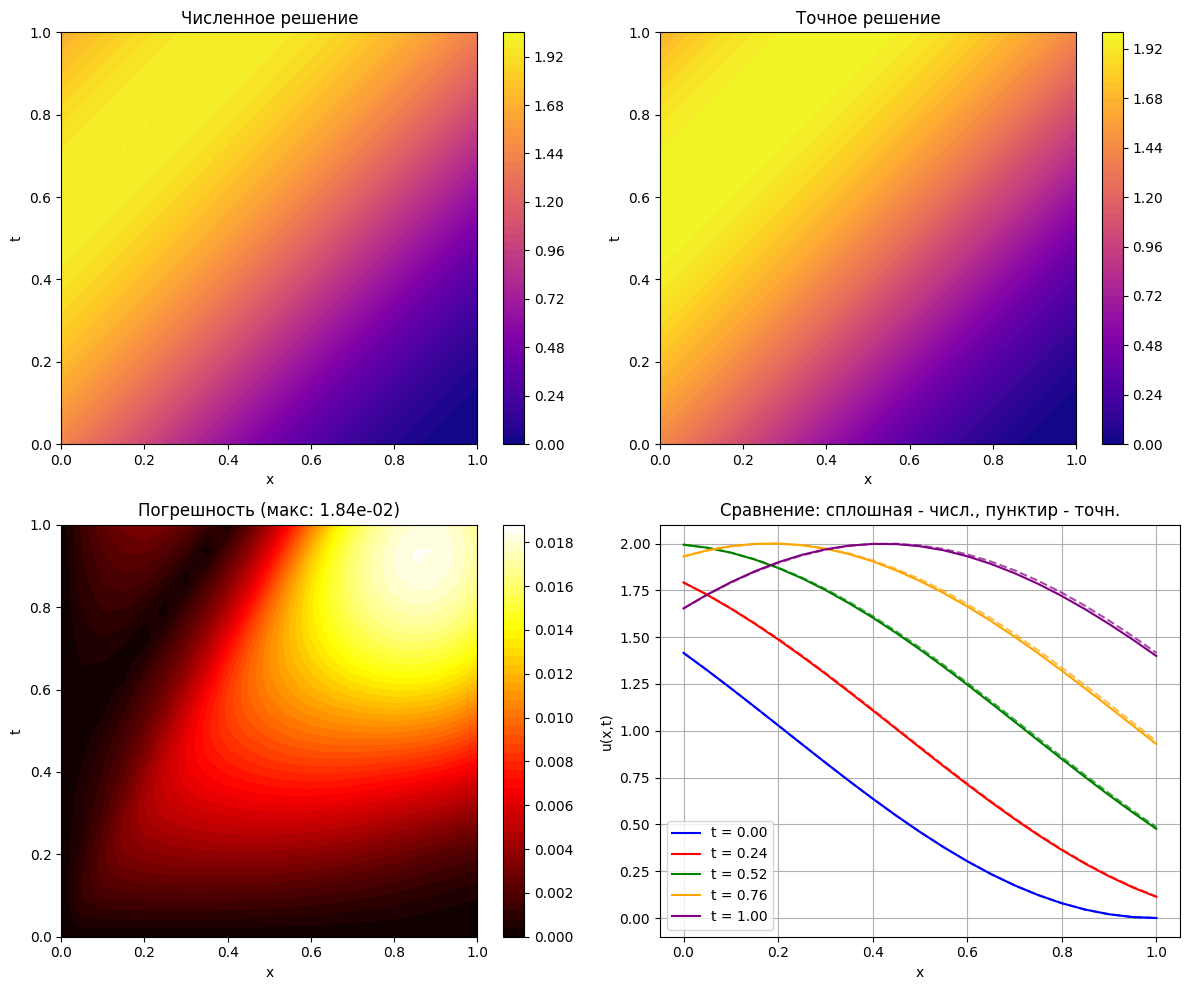

In [ ]:
error = calculate_error(u)
max_error = np.max(error)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

X, T = np.meshgrid(xs, ts)

ax1 = axes[0, 0]
contour1 = ax1.contourf(X, T, u.T, levels=50, cmap="plasma")
ax1.set_xlabel("x")
ax1.set_ylabel("t")
ax1.set_title("Численное решение")
plt.colorbar(contour1, ax=ax1)

ax2 = axes[0, 1]
exact_sol = np.array([u0(xs, t) for t in ts])
contour2 = ax2.contourf(X, T, exact_sol, levels=50, cmap="plasma")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_title("Точное решение")
plt.colorbar(contour2, ax=ax2)

ax3 = axes[1, 0]
contour3 = ax3.contourf(X, T, error.T, levels=50, cmap="hot")
ax3.set_xlabel("x")
ax3.set_ylabel("t")
ax3.set_title(f"Погрешность (макс: {max_error:.2e})")
plt.colorbar(contour3, ax=ax3)

ax4 = axes[1, 1]
time_indices = [0, len(ts)//4, len(ts)//2, 3*len(ts)//4, -1]
colors = ["blue", "red", "green", "orange", "purple"]

for idx, color in zip(time_indices, colors):
    t_val = ts[idx]
    ax4.plot(xs, u[:, idx], color=color,
            label=f"t = {t_val:.2f}")
    exact_vals = u0(xs, t_val)
    ax4.plot(xs, exact_vals, color=color, linestyle="--", alpha=0.7)

ax4.set_xlabel("x")
ax4.set_ylabel("u(x,t)")
ax4.set_title("Сравнение: сплошная - числ., пунктир - точн.")
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()